# Bragg grating

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import shutil
from IPython import display

import meep as mp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys
sys.path.append('../../lib')
from ataitmeep import *
import ataitbragg
from ataitbragg import bragg_cell, bragg_geometry, livefield

In [6]:
from lightlab.util import io
from lightlab.util.data import Spectrum, FunctionBundle, MeasuredFunction

In [7]:
io.dataHome /= 'reflectors'

-----------
Initializing structure...
run 0 finished at t = 0.0 (0 timesteps)


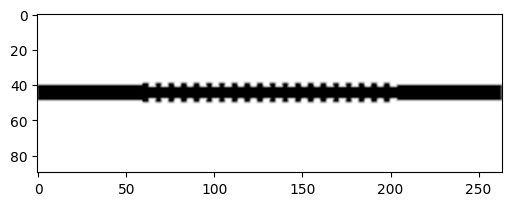

In [10]:
# Do the simulation, and verify the geometry
sim = mp.Simulation(
#                     progress_interval=1e6,
                    **ataitbragg.sim_kwargs())

eps_data = show_geometry(sim)

run 1 finished at t = 160.0 (9600 timesteps)


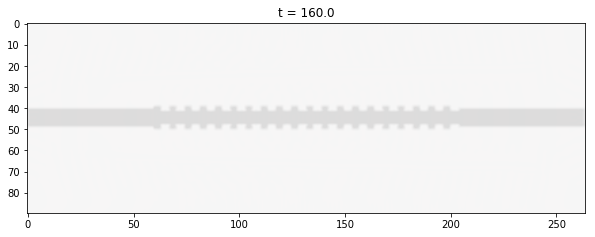

In [11]:
def plot_sim(until=200):
    sim.reset_meep()
    shutil.rmtree('outputs', ignore_errors=True)
    sim.use_output_directory('outputs')
    sim.run(
            mp.at_beginning(livefield),
            mp.at_every(5, livefield),
#             mp.at_every(1, mp.output_png(mp.Ey, "-Zc dkbluered")),
#             mp.to_appended("ez", mp.at_every(0.6, mp.output_efield_z)),
            until=until)
    # now make the gif
#     subprocess.check_call(['convert', 'outputs/ey-*.png', 'ey.gif'])
#     subprocess.check_call(['open', '-a', 'Safari', 'ey.gif'])

plt.figure(figsize=(10,6))
plot_sim(160)

field decay(t = 160.10000000000002): 2.8717928140288555e-07 / 0.0824930476000678 = 3.481254357278098e-06
run 0 finished at t = 160.10000000000002 (12808 timesteps)


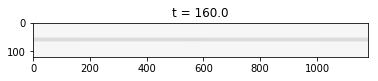

In [72]:
# Ok first do the straight waveguide
def do_baseline(do_live=True, geo=None, **kwargs):
    kwargs['dw'] = 0
    sim, refl, tran = ataitbragg.do_simrun(base_refl_data=None, do_live=do_live, geo=None, **kwargs)
    
    # for normalization run, save flux fields data for reflection plane
    straight_refl_data = sim.get_flux_data(refl)
    # This one is to normalize power. the other was to negate forward-propagating wave
    straight_tran_flux = mp.get_fluxes(tran)
    return straight_refl_data, straight_tran_flux

straight_refl_data, straight_tran_flux = do_baseline()  # comment this when you dont need to do it again

field decay(t = 220.13750000000002): 4.6832795163423944e-05 / 0.07705215729901739 = 0.0006078064106846387
run 0 finished at t = 220.13750000000002 (17611 timesteps)


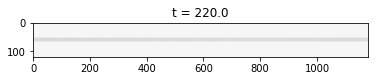

In [73]:
def do_trial(base_refl_data, do_live=True, geo=None, **kwargs):
    _, refl, tran = ataitbragg.do_simrun(base_refl_data=base_refl_data, do_live=do_live, geo=geo, **kwargs)
    return refl, tran
#     bend_refl_flux = np.array(mp.get_fluxes(refl))
#     flux_freqs = np.array(mp.get_flux_freqs(refl))
#     return bend_refl_flux, flux_freqs

refl, tran = do_trial(straight_refl_data, do_live=True)

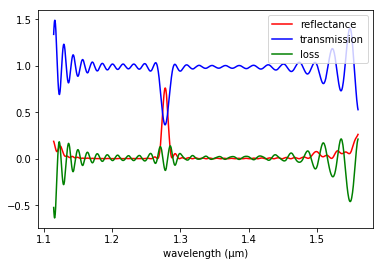

In [74]:
flux_freqs = np.array(mp.get_flux_freqs(refl))
wl = 1 / flux_freqs
Rs = -np.array(mp.get_fluxes(refl))/np.array(straight_tran_flux)
Ts = np.array(mp.get_fluxes(tran))/np.array(straight_tran_flux)
# spct = Spectrum(wl[::-1], Rs[::-1], inDbm=False)
# spct.crop([1.1,1.2]).simplePlot('.')
plt.plot(wl,Rs,'r-',label='reflectance')
plt.plot(wl,Ts,'b-',label='transmission')
plt.plot(wl,1-Rs-Ts,'g-',label='loss')
# plt.axis([1.0, 1.44, 0, 1])
# plt.ylim([0,1])
plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")



In [ ]:
# parameter sweep
isResimulating = True
isSaving = True
filename = 'bragg-periods.pkl'

# ataitbragg.resolution = 30
ataitbragg.set_sim2()

# pname, pvals = 'n_periods', [25, 50, 75, 100]
# pname, pvals = 'dw', np.linspace(.23, .24, 5)# [.23, .24, .25, .26]
pname, pvals = 'pitch', ataitbragg.default_geo.pitch + np.linspace(0, 1, 3) * .03
# pname, pvals = 'buffer', [2, 4, 6, 8, 10]

if isResimulating:
    spR = FunctionBundle()
    spT = FunctionBundle()
    spectra = (spR, spT)
    refreshing_baseline = pname in ['n_periods', 'sm_width', 'thickness', 'pitch'] or True
    if not refreshing_baseline:
        straight_refl_data, straight_tran_flux = do_baseline(do_live=False, buffer=10)
    for p in pvals:
        print()
        print(pname, '=', p)
        geo_kwarg = {pname: p}
        if refreshing_baseline:
            straight_refl_data, straight_tran_flux = do_baseline(do_live=False, **geo_kwarg)
#         bend_refl_flux, flux_freqs = do_trial(straight_refl_data, do_live=False, **geo_kwarg)
        refl, tran = do_trial(straight_refl_data, do_live=False, **geo_kwarg)
        flux_freqs = np.array(mp.get_flux_freqs(refl))
        wl = 1 / flux_freqs
        Rs = -np.array(mp.get_fluxes(refl)) / straight_tran_flux
        Ts = np.array(mp.get_fluxes(tran)) / straight_tran_flux
        spctR = Spectrum(wl[::-1], Rs[::-1], inDbm=False)
        spctT = Spectrum(wl[::-1], Ts[::-1], inDbm=False)
        spR.addDim(spctR.db())
        spT.addDim(spctT.db())
    if isSaving:
        io.savePickleGzip(dataTuple=(pname, pvals, spectra), filename=filename)
    # Notify that it is done
    applescript = """
    display dialog "Simulation is done" ¬
    with title "Pop-up window" ¬
    with icon caution ¬
    buttons {"OK"}
    """
    subprocess.call("osascript -e '{}'".format(applescript), shell=True)
else:
    pname, pvals, spectra = io.loadPickleGzip(filename=filename)



pitch = 0.229
-----------
Initializing structure...
field decay(t = 20.016666666666666): 4.722835246872401e-128 / 4.722835246872401e-128 = 1.0
field decay(t = 40.03333333333333): 1.5684731823761133e-09 / 1.5684731823761133e-09 = 1.0
field decay(t = 60.05): 8.614625973711568e-09 / 8.614625973711568e-09 = 1.0
field decay(t = 80.05): 2.2308703684258368e-07 / 2.2308703684258368e-07 = 1.0
field decay(t = 100.06666666666666): 0.0014137170057091388 / 0.0014137170057091388 = 1.0
field decay(t = 120.08333333333333): 1.410553543496179e-05 / 0.0014137170057091388 = 0.00997762308722195
field decay(t = 140.1): 1.2543559039945347e-08 / 0.0014137170057091388 = 8.872751045145232e-06
run 0 finished at t = 140.1 (8406 timesteps)
-----------
Initializing structure...
field decay(t = 20.016666666666666): 3.799799016838537e-128 / 3.799799016838537e-128 = 1.0
field decay(t = 40.03333333333333): 1.4286966245908072e-09 / 1.4286966245908072e-09 = 1.0
field decay(t = 60.05): 8.178075647958145e-09 / 8.178075647

Text(0.5,1,'Loss')

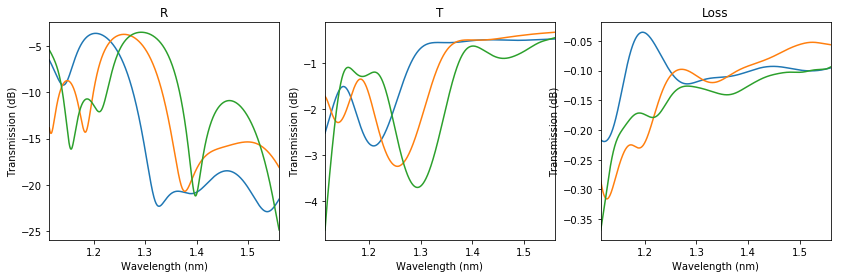

In [92]:
fi, ax = plt.subplots(ncols=3, figsize=(14, 4))
# spectra = list(spectra)
# spectra[0] = spectra[0].crop((1.15, 1.30))
# spectra[1] = spectra[1].crop((1.15, 1.30))
plt.sca(ax[0])
spectra[0].simplePlot()
plt.title('R')
plt.sca(ax[1])
spectra[1].simplePlot()
plt.title('T')
plt.sca(ax[2])
((spectra[0].lin() + spectra[1].lin() - 1)).db().simplePlot()
plt.title('Loss')
# sp = spectra[0]
# sp.lin().simplePlot()
# spct.db().simplePlot()

Text(0.5,1,'Loss')

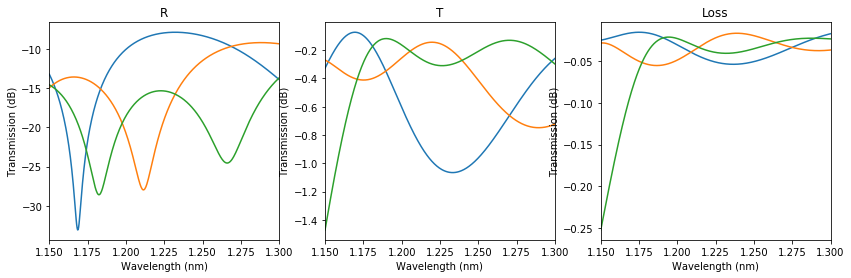

In [63]:
fi, ax = plt.subplots(ncols=3, figsize=(14, 4))
spectra = list(spectra)
spectra[0] = spectra[0].crop((1.15, 1.30))
spectra[1] = spectra[1].crop((1.15, 1.30))
plt.sca(ax[0])
spectra[0].simplePlot()
plt.title('R')
plt.sca(ax[1])
spectra[1].simplePlot()
plt.title('T')
plt.sca(ax[2])
((spectra[0].lin() + spectra[1].lin() - 1)).db().simplePlot()
plt.title('Loss')

### To get an accurate view of loss, you need to have longer buffers
Reflection is pretty accurate at 2um
Transmission good at 4um
Loss needs 10um or 20um for perfection

### Todo
Todo: eigenmode detector flux region
Todo: multiprocessing
